# TSIA202b - Analysis and synthesis of bell sounds
### Adam Chgour & Rayane Dakhlaoui

In [144]:
import os, sys, wave, struct

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import IPython

from copy import deepcopy
from math import ceil, exp, atan, pi, cos, sin
from scipy.io.wavfile import write
#import scipy.io.wavfile
from scipy.linalg import hankel
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import pylab as p
#import matplotlib.axes3d as p3
import mpl_toolkits.mplot3d.axes3d as p3
from scipy.signal import periodogram

# Useful functions

In [145]:
def load_sound(file):
    return wave.open(file, 'rb')

def plot_sound(data, times,xlim1,xlim2,name='default_name', save=False,w=20,h=10, lw = 3):
    plt.figure(figsize=(w, h))
    plt.plot(times,x.reshape(len_x))
    plt.xlim(xlim1,xlim2)
    plt.xlabel('time (s)')
    plt.ylabel('amplitude')
    if save:
        plt.savefig(name+'.png', dpi=100)
    plt.show()
    
def read_values(filename):
    wave_file = wave.open(filename, 'r')
    nframes = wave_file.getnframes()
    nchannels = wave_file.getnchannels()
    sampling_frequency = wave_file.getframerate()
    T = nframes / float(sampling_frequency)
    read_frames = wave_file.readframes(nframes)
    wave_file.close()
    data = struct.unpack("%dh" %  nchannels*nframes, read_frames)
    
    data_per_channel = [data[offset::nchannels] for offset in range(nchannels)]
    return T, np.array(data_per_channel), nframes, nchannels, sampling_frequency

In [146]:
def Synthesis(N,delta,f,a,phi,RSB=False):
    t = range(N)
    logz = delta + 1j*2*np.pi*f
    alpha = a*np.exp(1j*phi)
    x = np.sum(np.outer(alpha, np.ones(N))*np.exp(np.outer(logz,t)), axis=0)
    if RSB == False: 
        s = x
    else: 
        Ex = np.real(np.sum(np.abs(x)**2))/N
        b = np.random.normal(size=N) + 1j*np.random.normal(size=N)
        Eb = np.real(np.sum(np.abs(b)**2))/N
        b = b*np.sqrt(Ex/Eb)*10**(-RSB/20)
        s = x+b    
    return s

# Open audio file

In [147]:
wavefile = load_sound('ClocheB.WAV')
print(wavefile.getparams())

_wave_params(nchannels=1, sampwidth=2, framerate=8000, nframes=99414, comptype='NONE', compname='not compressed')


In [148]:
IPython.display.Audio('ClocheB.WAV')

In [149]:
T, data, nframes, nchannels, sampling_frequency = read_values('ClocheA.WAV')
Fs = int(wavefile.getframerate())
x = np.array(data)
num_samples = int(wavefile.getnframes())

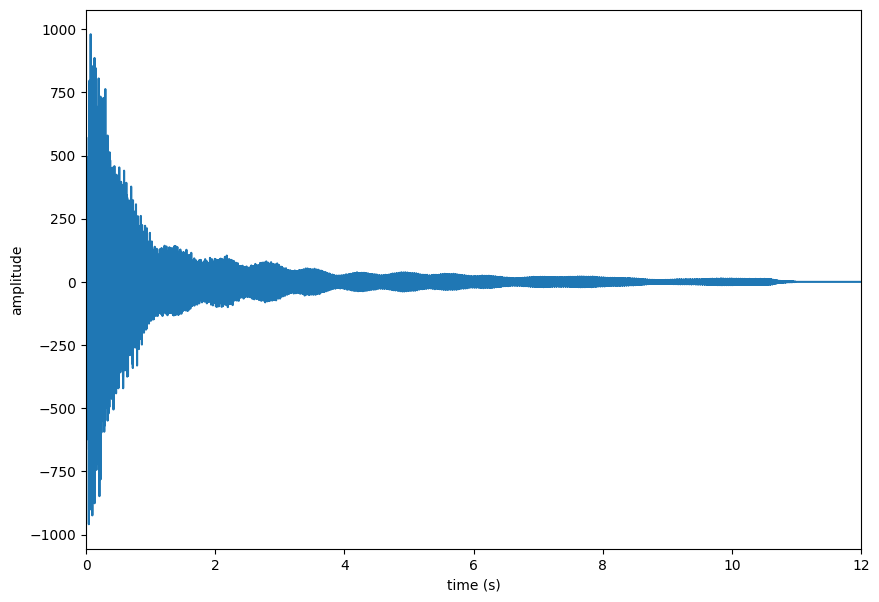

In [150]:
len_x = x.shape[1]
timestep = 1/(float(Fs))
times = np.arange(len_x)*timestep # int(len_x/6)
plot_sound(x.reshape(len_x), times,0,12,w=10,h=7)

In [151]:
write('new_bell.wav', Fs, np.array(x.reshape(len_x), dtype=np.int16)) # to write a new wave file

## 3 Synthetic signal
### 3.1 Spectral analysis by Fourier transform

In [152]:
#Paramètres
N = 63
f0 = 1/4
f1 = f0 + 1/N
a0 = 1
a1 = 10
delta0 = 0
delta1 = -0.05
phi0 = np.random.uniform(-np.pi,np.pi)
phi1 = np.random.uniform(-np.pi,np.pi)
Fs = 1000
f = np.array([f0,f1])
a = np.array([a0,a1])
delta = np.array([delta0,delta1])
phi = np.array([phi0,phi1])


#Synthesis
x = Synthesis(N,delta,f,a,phi)

/Users/rayanedakhlaoui/Library/Python/3.9/lib/python/site-packages/scipy/signal/_spectral_py.py:454: UserWarning: Input data is complex, switching to return_onesided=False
  freqs, Pxx = csd(x, x, fs=fs, window=window, nperseg=nperseg,


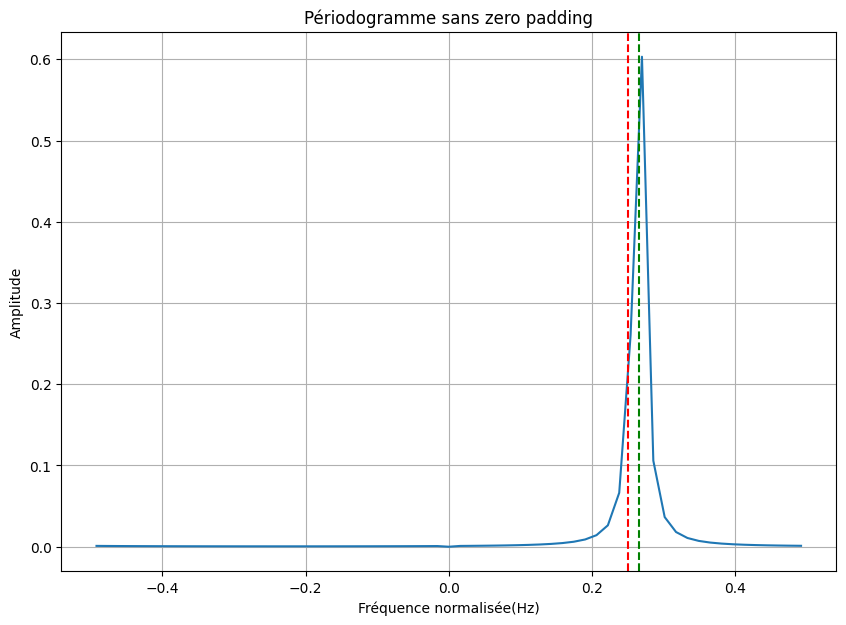

In [153]:
# Périodogramme sans zero padding
X = periodogram(x, fs=Fs)
frequencies = np.fft.fftshift(X[0] - X[0].mean())  # fréquences en Hz centrées autour de 0
norm_frequencies = frequencies / Fs  # conversion en cycles par échantillon

plt.figure(figsize=(10, 7))
plt.plot(norm_frequencies, np.fft.fftshift(X[1]))
plt.axvline(f0, color='r', linestyle='--', label=f'f0 = {f0:.3f}')
plt.axvline(f1, color='g', linestyle='--', label=f'f1 = {f1:.3f}')
plt.xlabel('Fréquence normalisée(Hz)')
plt.ylabel('Amplitude')
plt.title('Périodogramme sans zero padding')
plt.grid()
plt.show()

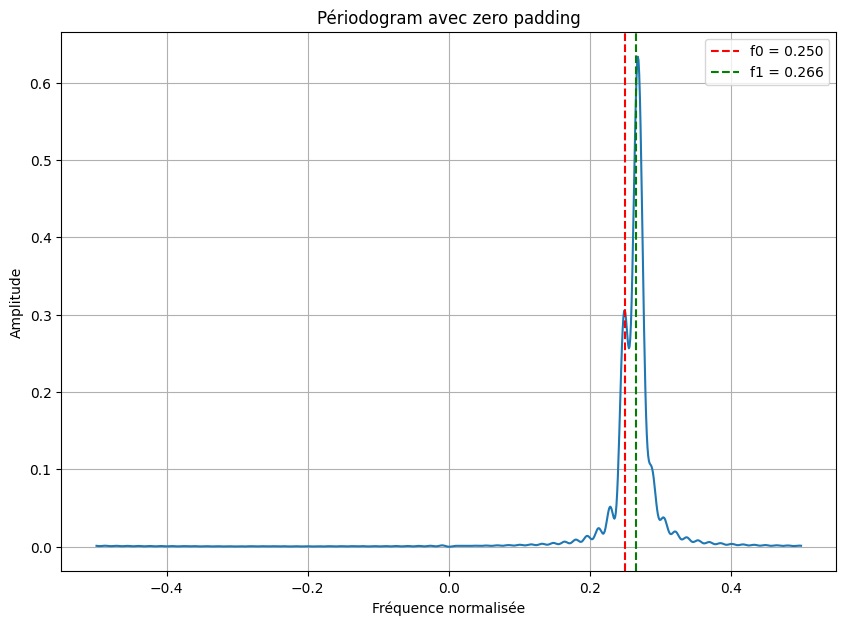

In [154]:
# Périodogramme avec zero padding
NFFT = 1024
X = periodogram(x, fs=Fs, nfft=NFFT)
frequencies = np.fft.fftshift(X[0] - X[0].mean())  
norm_frequencies = frequencies / Fs  

plt.figure(figsize=(10, 7))
plt.plot(norm_frequencies, np.fft.fftshift(X[1]))
plt.axvline(f0, color='r', linestyle='--', label=f'f0 = {f0:.3f}')
plt.axvline(f1, color='g', linestyle='--', label=f'f1 = {f1:.3f}')
plt.xlabel('Fréquence normalisée')
plt.ylabel('Amplitude')
plt.title('Périodogram avec zero padding')
plt.legend()
plt.grid()
plt.show()

**<u>Observations</u>** Sans zero-padding, les deux pics sont indistinguables car la résolution de Fourier (1/N) est exactement égale à l’écart entre les deux fréquences et donc elles se confondent.

Avec zero-padding, visuellement les pics sont mieux séparés car l'interpolation rend le spectre plus lisse, mais la résolution effective reste limitée par 1/N. Le zero-padding améliore l'affichage mais n'améliore pas réellement la capacité de séparation.

**<u>Conclusion</u>** La Transformée de Fourier ne permet pas de bien séparer deux fréquences aussi proches, même avec du zero-padding.

### 3.2 High resolution methods


Empirical covaraiance matrix

In [155]:
# Paramètres
n = 32
K = 2
N = len(x)
l = N - n + 1

# Matrice de Hankel  
X = np.array(hankel(x[:n], x[l-1:]))
Rxx = np.dot(X, X.conj().T) / l

Estimation of the signal subspace

In [156]:
U1, Lambda, U2 = np.linalg.svd(Rxx)
W = U1[:, :K]
#print(W.shape)

### 3.2.1 ESPRIT method

Estimation of the frequencies and damping factors

In [157]:
W_down = W[:-1, :]  
W_up = W[1:, :]    
Phi = np.linalg.pinv(W_down) @ W_up
eigenvalues, eigenvectors = np.linalg.eig(Phi)

damping = np.log(np.abs(eigenvalues)) 
frequency = np.angle(eigenvalues) / (2 * np.pi)
print(damping,  frequency)

[-0.05  0.  ] [0.26587302 0.25      ]


**<u>Observation:</u>** ESPRIT fournit les bonnes fréquences et valeurs d'amortissement pour notre signal synthétisé

Estimation of the amplitudes and phases

In [159]:
# Compute the Vandermonde matrix V_N
t = np.arange(N).reshape(-1, 1)  # Column vector of time indices
z = delta + 1j * 2 * np.pi * f  
V = np.exp(np.dot(t, z.reshape(1, -1)))  

x = x.reshape(-1, 1)

alpha = np.dot(np.linalg.pinv(V), x) 
a_ls = np.array([np.abs(alpha_k) for alpha_k in alpha])
phase_ls = np.array([np.angle(alpha_k) for alpha_k in alpha])

print(a_ls)

[[ 1.]
 [10.]]


Application to synthetic signals

In [50]:
def least_squares(x, delta, f):
    N = len(x)
    t = np.arange(N).reshape(-1, 1) 
    z = delta + 1j * 2 * np.pi * f  
    V = np.exp(np.dot(t, z.reshape(1, -1)))  
    alpha = np.dot(np.linalg.pinv(V), x) 
    
    a = np.abs(alpha) 
    phi = np.angle(alpha)  
    
    return a, phi

In [51]:
def Esprit(x, n, K):
    l = len(x) - n + 1
    X_hankel = np.array(hankel(x[:n], x[l-1:]))
    X_hankel_H = np.conjugate(X_hankel.T)
    Rxx = np.dot(X_hankel, X_hankel_H) / l
    U1, Lambda, U2 = np.linalg.svd(Rxx)
    W = U1[:, :K]
    W_down = W[:-1, :]  
    W_up = W[1:, :] 
    Phi = np.linalg.pinv(W_down) @ W_up
    vp_phi = np.linalg.eig(Phi)[0]
    damping = np.log(np.abs(vp_phi))
    frequency = np.angle(vp_phi) / (2 * np.pi)
    return damping, frequency


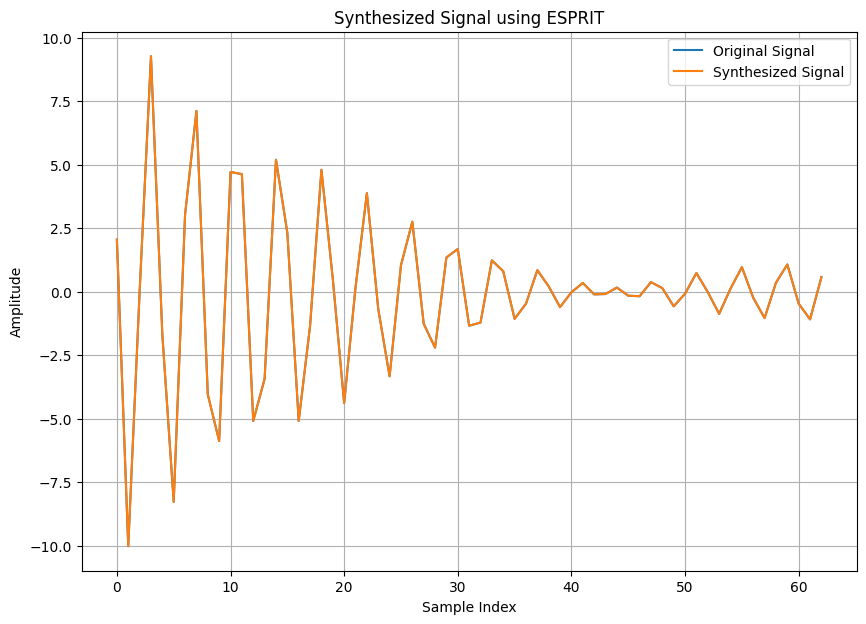

In [52]:
delta_esprit, freq_esprit = Esprit(x, n, K)
a_ls, phi_ls = least_squares(x, delta_esprit, freq_esprit)

Y = Synthesis(N, delta_esprit, freq_esprit, a_ls, phi_ls)

# Visualisation
plt.figure(figsize=(10, 7))
plt.plot(x, label='Original Signal')
plt.plot(Y, label='Synthesized Signal') 
plt.title('Synthesized Signal using ESPRIT')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.legend()
plt.grid()
plt.show()


### 3.2.2 MUSIC method

MUSIC pseudo-spectrum

In [54]:
from scipy.signal import find_peaks

def MUSIC(x, n, K, delta_range=(-0.1, 0.1), f_range=(0, 1), grid_points=50):

    l = len(x) - n + 1
    X = np.array(hankel(x[:n], x[l-1:]))
    

    Rxx = np.dot(X, X.conj().T) / l
    

    U, S, Vh = np.linalg.svd(Rxx)
    

    noise_subspace = U[:, K:]
    

    delta_vals = np.linspace(delta_range[0], delta_range[1], grid_points)
    f_vals = np.linspace(f_range[0], f_range[1], grid_points)
    delta_grid, f_grid = np.meshgrid(delta_vals, f_vals)
    

    pseudo_spectrum = np.zeros_like(delta_grid, dtype=float)
    for i in range(delta_grid.shape[0]):
        for j in range(delta_grid.shape[1]):
            z = delta_grid[i, j] + 1j * 2 * np.pi * f_grid[i, j]
            steering_vector = np.exp(np.outer(np.arange(n), z))
            pseudo_spectrum[i, j] = 1 / np.linalg.norm(np.dot(noise_subspace.conj().T, steering_vector))

    pseudo_spectrum = np.abs(pseudo_spectrum)
    
    plt.figure(figsize=(10, 7))
    plt.contourf(f_grid, delta_grid, np.log(pseudo_spectrum), levels=50, cmap='magma')
    plt.pcolormesh(f_grid, delta_grid, np.log(pseudo_spectrum), shading='auto', cmap='magma')
    plt.xlabel('Frequency (f)')
    plt.ylabel('Damping (δ)')
    plt.title('MUSIC Pseudo-Spectrum')
    plt.grid()
    plt.show()
    

    peaks = find_peaks(pseudo_spectrum.flatten(), height=np.max(pseudo_spectrum) * 0.5)[0]
    delta_peaks = delta_grid.flatten()[peaks]
    f_peaks = f_grid.flatten()[peaks]
    
    print("Identified Poles:")
    for i in range(len(peaks)):
        print(f"δ = {delta_peaks[i]:.4f}, f = {f_peaks[i]:.4f}")
    
    return delta_peaks, f_peaks

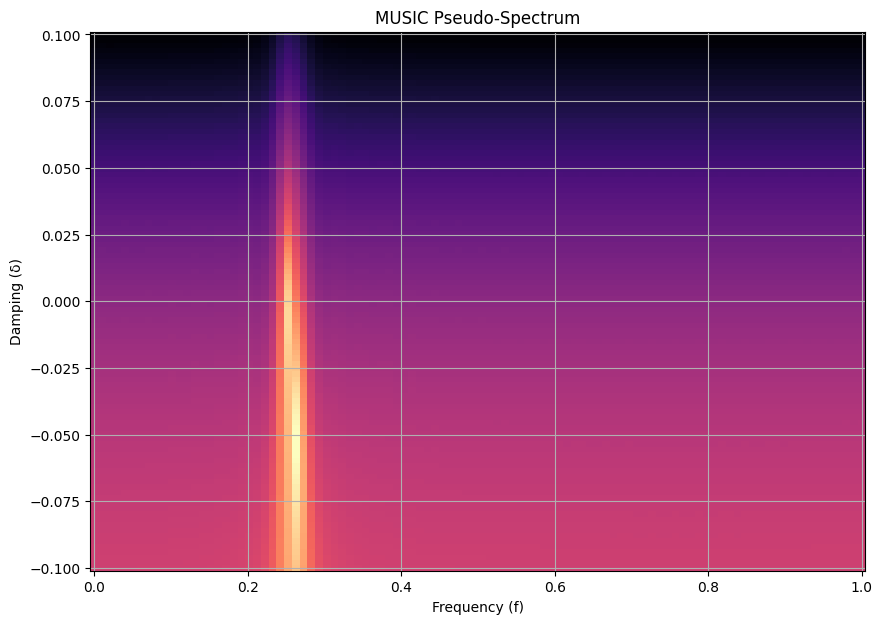

Identified Poles:
δ = -0.0051, f = 0.2525
δ = -0.0535, f = 0.2626


In [55]:
delta_peaks, f_peaks = MUSIC(x, n=32, K=2, grid_points=100)

## 4. Audio signals
### 4.1 Spectral analysis by Fourier transform

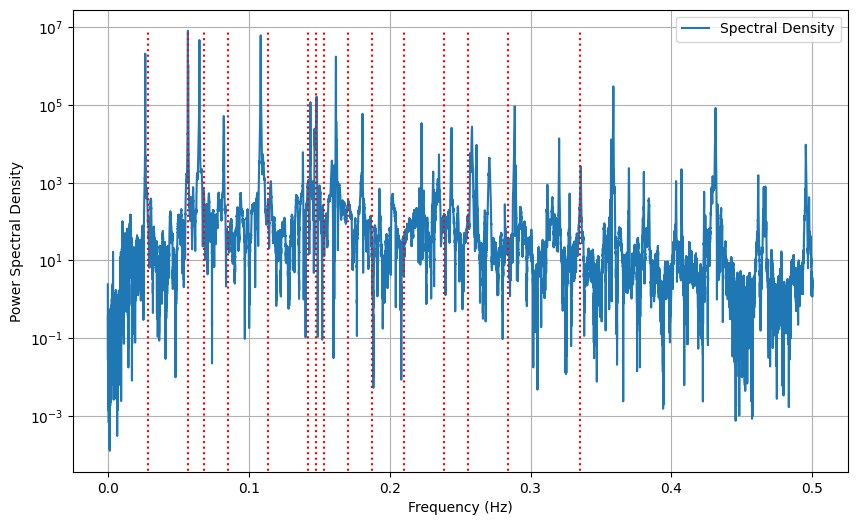

In [56]:
T, data, nframes, nchannels, sampling_frequency = read_values('ClocheA.WAV')
n = len(data)
x = np.array(data)
len_x = x.shape[1]
x = x.reshape(len_x)

fs=1
n = len(x)
f = np.fft.rfftfreq(n, 1/fs)
fft = np.fft.rfft(x)
psd = np.abs(fft)**2/n

max_freq = (f[:n//2])[list(psd[:n//2]).index(max(psd[:n//2]))] # Fundamental / prime frequency
max_psd = max(psd[:n//2])
ratios = [0.5,1,1.2,1.5,2,2.5,2.6,2.7,3,3.3,3.7,4.2,4.5,5,5.9]

plt.figure(figsize=(10, 6))
plt.semilogy(f[:n//2], psd[:n//2], label='Spectral Density')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density')
plt.vlines(max_freq*np.array(ratios),ymin = [0 for i in range(len(ratios))], ymax = [max_psd for i in range(len(ratios))], colors=['red' for i in range(len(ratios))], linestyles=['dotted' for i in range(len(ratios))])
plt.legend()
plt.grid(True)
plt.show()

**<u>Observations:</u>** On observe que les fréquences propres sont proches de celles annoncées en introduction (lignes rouges, en prenant pour fréquence principale celle où la densité spectrale de puissance est maximale).

In [57]:
T, data, nframes, nchannels, sampling_frequency = read_values('ClocheA.WAV')
Fs = int(wavefile.getframerate())
x = np.array(data)
num_samples = int(wavefile.getnframes())

freq, X = periodogram(x, fs=1000, nfft=NFFT)

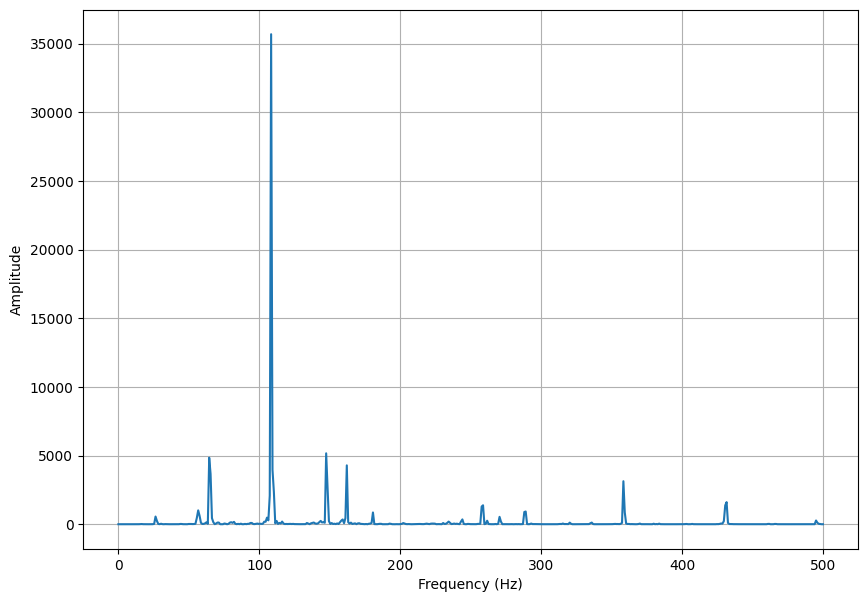

In [58]:
plt.figure(figsize=(10, 7))
plt.plot(freq, X[0])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.grid()
plt.show()

In [59]:
eigenfrequencies = {
    "bourdon": 0.5,
    "fondamentale": 1,
    "tierce mineure": 1.2,
    "quinte": 1.5,
    "octave": 2,
    "doubl octave": 4,
    "tierce majeure": 3.3,
    "quarte juste": 4.5,
    "quinte diminuée": 5,
    "sixte majeure": 5.9
}

Identified Peaks: [111]
Peak at frequency: 56.640625 Hz
Peak at frequency: 64.453125 Hz
Peak at frequency: 65.4296875 Hz
Peak at frequency: 107.421875 Hz
Peak at frequency: 108.3984375 Hz
Peak at frequency: 109.375 Hz
Peak at frequency: 110.3515625 Hz
Peak at frequency: 147.4609375 Hz
Peak at frequency: 148.4375 Hz
Peak at frequency: 162.109375 Hz
Peak at frequency: 257.8125 Hz
Peak at frequency: 258.7890625 Hz
Peak at frequency: 289.0625 Hz
Peak at frequency: 358.3984375 Hz
Peak at frequency: 430.6640625 Hz
Peak at frequency: 431.640625 Hz


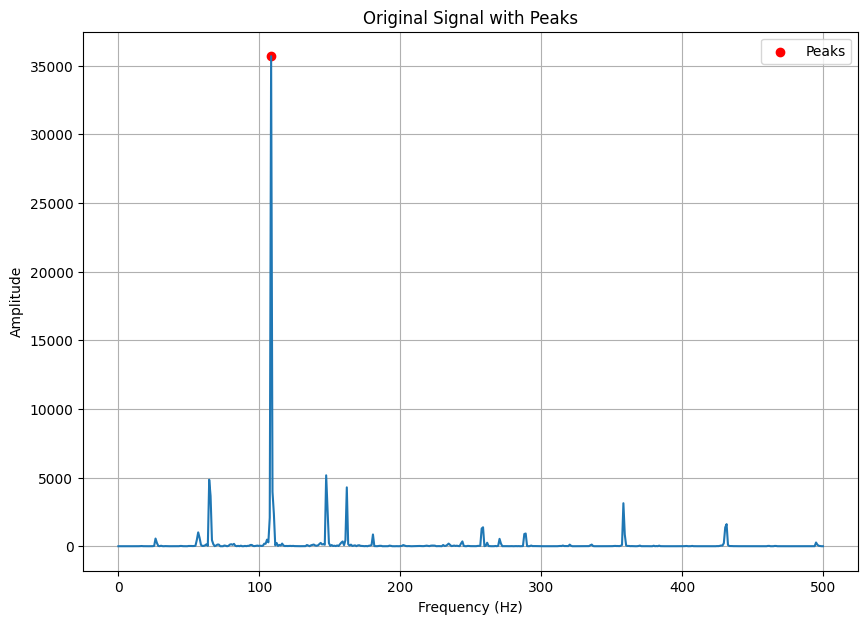

In [60]:
fp = find_peaks(X[0], height=np.max(X[0]) * 0.5)[0]
print("Identified Peaks:", fp)

peaks = []
for i, f in enumerate(freq):
    if X[0][i] > 0.05 * np.max(X[0]/2):
        print(f"Peak at frequency: {f} Hz")
        peaks.append(f)

plt.figure(figsize=(10, 7))
plt.plot(freq, X[0])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.title('Original Signal with Peaks')
plt.grid()
plt.scatter(freq[fp], X[0][fp], color='red', label='Peaks')
plt.legend()
plt.show()

In [61]:
for i in peaks:
    for eigenfreq_name, eigenfreq_value in eigenfrequencies.items():
        if abs(fp[0]/i - eigenfreq_value) < 0.5:
            print(f"Peak at {i} Hz corresponds to eigenfrequency {eigenfreq_name}")
            break
    else:
        print(f"Peak at {i} Hz does not correspond to any known eigenfrequency")

Peak at 56.640625 Hz corresponds to eigenfrequency quinte
Peak at 64.453125 Hz corresponds to eigenfrequency quinte
Peak at 65.4296875 Hz corresponds to eigenfrequency tierce mineure
Peak at 107.421875 Hz corresponds to eigenfrequency fondamentale
Peak at 108.3984375 Hz corresponds to eigenfrequency fondamentale
Peak at 109.375 Hz corresponds to eigenfrequency fondamentale
Peak at 110.3515625 Hz corresponds to eigenfrequency fondamentale
Peak at 147.4609375 Hz corresponds to eigenfrequency bourdon
Peak at 148.4375 Hz corresponds to eigenfrequency bourdon
Peak at 162.109375 Hz corresponds to eigenfrequency bourdon
Peak at 257.8125 Hz corresponds to eigenfrequency bourdon
Peak at 258.7890625 Hz corresponds to eigenfrequency bourdon
Peak at 289.0625 Hz corresponds to eigenfrequency bourdon
Peak at 358.3984375 Hz corresponds to eigenfrequency bourdon
Peak at 430.6640625 Hz corresponds to eigenfrequency bourdon
Peak at 431.640625 Hz corresponds to eigenfrequency bourdon


### 4.2 High resolution method

In [62]:
N = 4*Fs
start_index = 0
segment = x[0, start_index:start_index + N]

K = 54
n = 512
l = 1024

X = np.array(hankel(segment[:n], segment[n-1:]))

Rxx = np.dot(X, X.conj().T) / l

U, S, Vh = np.linalg.svd(Rxx)

W = U[:, :K]

W_down = W[:-1, :]
W_up = W[1:, :]

PHI = np.linalg.pinv(W_down) @ W_up

eigenvalues, _ = np.linalg.eig(PHI)
delta = np.log(np.abs(eigenvalues))
frequencies = np.angle(eigenvalues) / (2 * np.pi)

amplitudes, phases = least_squares(segment, delta, frequencies)

resynthesized_signal = Synthesis(N, delta, frequencies, amplitudes, phases)

IPython.display.Audio(resynthesized_signal.real, rate=sampling_frequency)

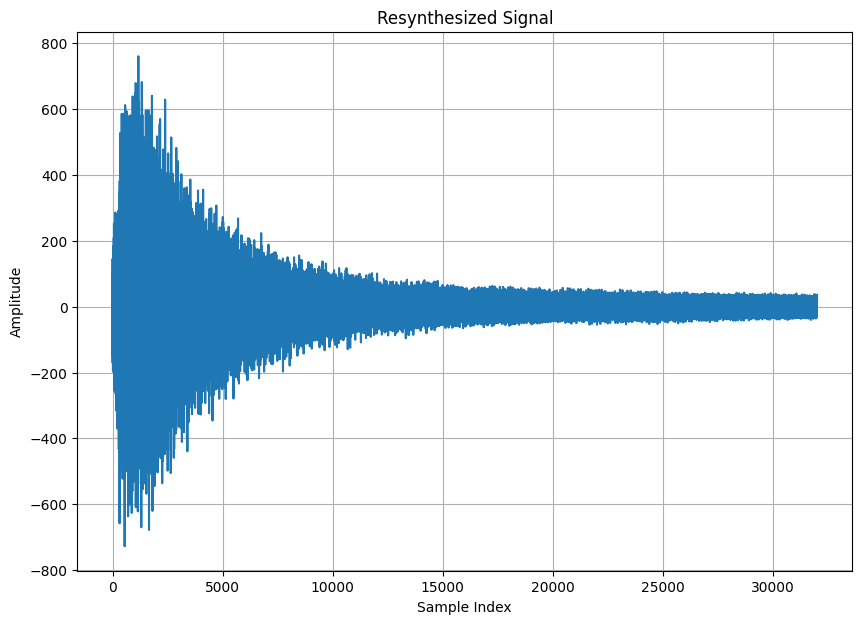

In [63]:
plt.figure(figsize=(10, 7))
plt.plot(resynthesized_signal.real)
plt.title('Resynthesized Signal')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.grid()
plt.show()

In [64]:
write('resynthesized_bell.wav', Fs, np.array(resynthesized_signal.real, dtype=np.int16))